In [63]:
# %matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import scipy.stats
%run 'parse.ipynb'
%run 'correlation_clustering_refactor.ipynb'

In [4]:
%matplotlib inline

# Load data

In [5]:
def loadData(data_type='training'):
    datadir = 'Behavioral-Analyzed-Data/{}/'.format(data_type)
    
    folders=[datadir+s for s in os.listdir(datadir) if len(s) <= 2]
    
    subjects = pd.DataFrame(folders,columns=['folder'])
    subjects.index = [int(s.split('/')[-1]) for s in subjects.folder]
    subjects.sort_index(inplace=True)
    
    subjects['data'] = [doparse(data_type = data_type, subj=i) for i in subjects.index]

    return subjects

In [6]:
subjects = loadData('training')
subjects.head()

,folder,data
1,Behavioral-Analyzed-Data/training/1,<__main__.Subject object at 0x7f7e0908c910>
2,Behavioral-Analyzed-Data/training/2,<__main__.Subject object at 0x7f7e08d7db90>
3,Behavioral-Analyzed-Data/training/3,<__main__.Subject object at 0x7f7e08d76790>
4,Behavioral-Analyzed-Data/training/4,<__main__.Subject object at 0x7f7e08ed0f90>
5,Behavioral-Analyzed-Data/training/5,<__main__.Subject object at 0x7f7e08edcd50>


# Dimensionality reduction

In [7]:
# A Reducer takes in a Subject object, defined above, and a bool "isPre"
# and returns a numpy vector.
# Eventually, it will have performed useful reduction in the process.

In [8]:
def nullRSreducer(subj, isPre = True):
    if isPre:
        return subj.Pre_RS.values.flatten()
    else:
        return subj.Post_RS.values.flatten()

In [9]:
def nullFSreducer(subj, isPre = True):
    if isPre:
        return subj.Pre_FS.values.flatten()
    else:
        return subj.Post_FS.values.flatten()

In [10]:
data = np.array([s.Pre_RS.values for s in subjects.data] + [s.Post_RS.values for s in subjects.data])
rdc = ClusterReducer(data)
def clusteringRSreducer(subj, isPre = True):
    if isPre:
        return rdc(subj.Pre_RS.values).flatten()
    else:
        return rdc(subj.Post_RS.values).flatten()

In [11]:
data = np.array([s.Pre_FS.values for s in subjects.data] + [s.Post_FS.values for s in subjects.data])
fdc = ClusterReducer(data)
def clusteringFSreducer(subj, isPre = True):
    if isPre:
        return fdc(subj.Pre_RS.values).flatten()
    else:
        return fdc(subj.Post_RS.values).flatten()

In [12]:
y_rdc = YeoReducer(ignored_regions)
def yeoRSreducer(subj, isPre=True):
    if isPre:
        return y_rdc(subj.Pre_RS.values).flatten()
    else:
        return y_rdc(subj.Post_RS.values).flatten()

# Similarity Matrices

In [13]:
def dist_func(vect1, vect2):
    return np.linalg.norm(vect1 - vect2)

In [14]:
def plotSimilarityMatrix(subjects, reducer):
    subjects = subjects.copy()
    subjects['reducedPre'] = [reducer(subj, True) for subj in subjects.data]
    subjects['reducedPost'] = [reducer(subj, False) for subj in subjects.data]
    
    distMatrix = np.zeros([len(subjects), len(subjects)])
    for i, post in subjects.reducedPost.iteritems():
        # For each post scan
        for j, pre in subjects.reducedPre.iteritems():
            # How similar is it to each pre scan
            distMatrix[i-1, j-1] = dist_func(pre, post)

    distMatrix /= np.nanmax(distMatrix)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(distMatrix)

    fig.colorbar(cax)
    # plt.title('Correlation between incomming and outgoing scans')
    ax.set_xlabel('Pre subject')
    ax.set_ylabel('Post subject')
    
    return fig

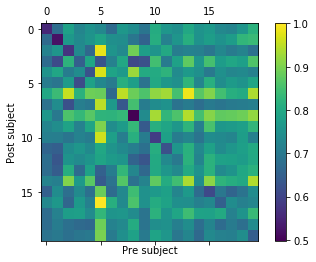

In [15]:
fig = plotSimilarityMatrix(subjects, nullRSreducer)

fig.savefig('DistanceMap_naiveRS.png', dpi=500, transparent=True)

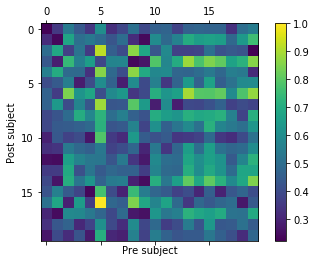

In [16]:
fig = plotSimilarityMatrix(subjects, clusteringRSreducer)

fig.savefig('DistanceMap_clusteredRS.png', dpi=500, transparent=True)

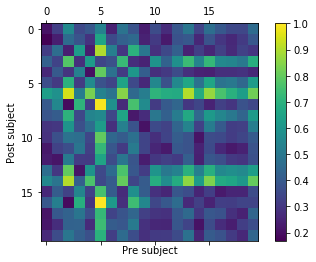

In [17]:
fig = plotSimilarityMatrix(subjects, yeoRSreducer)

fig.savefig('DistanceMap_yeoRS.png', dpi=500, transparent=True)

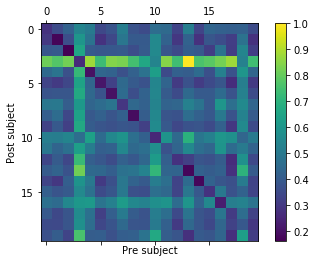

In [18]:
fig = plotSimilarityMatrix(subjects, nullFSreducer)

fig.savefig('DistanceMap_naiveFS.png', dpi=500, transparent=True)

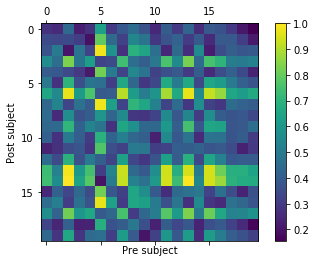

In [19]:
fig = plotSimilarityMatrix(subjects, clusteringFSreducer)

fig.savefig('DistanceMap_clusteredFS.png', dpi=500, transparent=True)

## Effect-size-like-stuff

In [20]:
reducer = nullFSreducer

subjects['reducedPre'] = [reducer(subj, True) for subj in subjects.data]
subjects['reducedPost'] = [reducer(subj, False) for subj in subjects.data]

In [21]:
postVariance = np.var(subjects.reducedPost.as_matrix())
print postVariance
subjects.reducedPost.as_matrix();

[     0.          62917.41722203  35689.63431792 ...,   9418.76314382
  18603.55662472      0.        ]


# Directionality modelling

In [22]:
reducer = nullFSreducer

subjects['reducedPre'] = [reducer(subj, True) for subj in subjects.data]
subjects['reducedPost'] = [reducer(subj, False) for subj in subjects.data]

In [23]:
subjects['delta'] = subjects.reducedPost - subjects.reducedPre
subjects.head()

,folder,data,reducedPre,reducedPost,delta
1,Behavioral-Analyzed-Data/training/1,<__main__.Subject object at 0x7f7e0908c910>,"[0.0, 411.6548583, 245.835252436, 227.17283950...","[0.0, 438.531027467, 256.727595386, 340.524038...","[0.0, 26.8761691673, 10.8923429502, 113.351198..."
2,Behavioral-Analyzed-Data/training/2,<__main__.Subject object at 0x7f7e08d7db90>,"[0.0, 266.594594595, 83.2254616132, 87.4235924...","[0.0, 549.92690678, 86.6288461538, 118.7257844...","[0.0, 283.332312185, 3.40338454063, 31.3021919..."
3,Behavioral-Analyzed-Data/training/3,<__main__.Subject object at 0x7f7e08d76790>,"[0.0, 893.836875359, 209.549833095, 164.518681...","[0.0, 714.309027778, 115.080357143, 120.571847...","[0.0, -179.527847581, -94.469475952, -43.94683..."
4,Behavioral-Analyzed-Data/training/4,<__main__.Subject object at 0x7f7e08ed0f90>,"[0.0, 370.537787514, 456.880110243, 251.801619...","[0.0, 730.798572157, 511.17877338, 271.5162548...","[0.0, 360.260784643, 54.2986631363, 19.7146354..."
5,Behavioral-Analyzed-Data/training/5,<__main__.Subject object at 0x7f7e08edcd50>,"[0.0, 744.692073171, 306.807620818, 136.982681...","[0.0, 702.096537251, 225.512285582, 110.604432...","[0.0, -42.5955359199, -81.295335236, -26.37824..."


In [24]:
meanDelta = np.mean(subjects.delta)
print meanDelta.shape
print meanDelta

(6724,)
[  0.           5.67110559  26.13523991 ..., -24.7314285  -37.2998799    0.        ]


In [25]:
subjects['forecastedPost'] = subjects.reducedPre + meanDelta
subjects.head()

,folder,data,reducedPre,reducedPost,delta,forecastedPost
1,Behavioral-Analyzed-Data/training/1,<__main__.Subject object at 0x7f7e0908c910>,"[0.0, 411.6548583, 245.835252436, 227.17283950...","[0.0, 438.531027467, 256.727595386, 340.524038...","[0.0, 26.8761691673, 10.8923429502, 113.351198...","[0.0, 417.325963887, 271.970492344, 253.084212..."
2,Behavioral-Analyzed-Data/training/2,<__main__.Subject object at 0x7f7e08d7db90>,"[0.0, 266.594594595, 83.2254616132, 87.4235924...","[0.0, 549.92690678, 86.6288461538, 118.7257844...","[0.0, 283.332312185, 3.40338454063, 31.3021919...","[0.0, 272.265700182, 109.360701521, 113.334965..."
3,Behavioral-Analyzed-Data/training/3,<__main__.Subject object at 0x7f7e08d76790>,"[0.0, 893.836875359, 209.549833095, 164.518681...","[0.0, 714.309027778, 115.080357143, 120.571847...","[0.0, -179.527847581, -94.469475952, -43.94683...","[0.0, 899.507980946, 235.685073003, 190.430054..."
4,Behavioral-Analyzed-Data/training/4,<__main__.Subject object at 0x7f7e08ed0f90>,"[0.0, 370.537787514, 456.880110243, 251.801619...","[0.0, 730.798572157, 511.17877338, 271.5162548...","[0.0, 360.260784643, 54.2986631363, 19.7146354...","[0.0, 376.208893101, 483.015350152, 277.712992..."
5,Behavioral-Analyzed-Data/training/5,<__main__.Subject object at 0x7f7e08edcd50>,"[0.0, 744.692073171, 306.807620818, 136.982681...","[0.0, 702.096537251, 225.512285582, 110.604432...","[0.0, -42.5955359199, -81.295335236, -26.37824...","[0.0, 750.363178758, 332.942860726, 162.894054..."


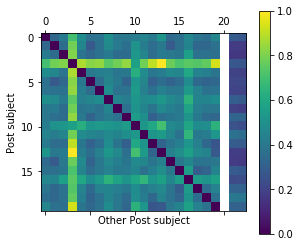

In [26]:
dirMatrix = np.zeros([len(subjects), len(subjects) + 3])
for i, post in subjects.reducedPost.iteritems():
    # For each post scan
    for j, otherpost in subjects.reducedPost.iteritems():
        # How similar is it to each pre scan
        dirMatrix[i-1, j-1] = dist_func(post, otherpost)
    
    # How similar is it to its own pre scan?
    dirMatrix[i-1,-1] = dist_func(subjects.forecastedPost[i], post)
    # How similar is it to the prediction?
    dirMatrix[i-1,-2] = dist_func(subjects.reducedPre[i], post)
    
    dirMatrix[i-1,-3] = float('nan')

dirMatrix /= np.nanmax(dirMatrix)

cax = plt.matshow(dirMatrix)

plt.colorbar(cax)
# plt.title('Correlation between incomming and outgoing scans')
plt.xlabel('Other Post subject')
plt.ylabel('Post subject')

plt.savefig('DirectionMap.png', dpi=500, transparent=True)

In [66]:
def plotRegionalChange(subjects, reducer):
    subjects = subjects.copy()
    subjects['reducedPre'] = [reducer(subj, True) for subj in subjects.data]
    subjects['reducedPost'] = [reducer(subj, False) for subj in subjects.data]
    
    pre  = subjects.reducedPre.values
    post = subjects.reducedPost.values
    
    pre = np.stack(pre, axis=0)
    post = np.stack(post, axis=0)
    
    delta = (post - pre) # 20xN
    
    # anova
    N = delta.shape[-1]
    deltas = np.split(delta, N, axis=1)
    anova = scipy.stats.f_oneway(*deltas)
    print anova
    
    delta = np.nanmean(delta, axis=0)
    #delta /= np.nanmax(delta)
    
    n = int(np.sqrt(delta.shape[0]))
    
    delta = np.reshape(delta, (n,n))

    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(delta)

    fig.colorbar(cax)
    # plt.title('Correlation between incomming and outgoing scans')
    ax.set_xlabel('Regions')
    ax.set_ylabel('Regions')
    
    return fig

F_onewayResult(statistic=array([ 1.10217346]), pvalue=array([  7.05799492e-78]))


<IPython.core.display.Javascript object>


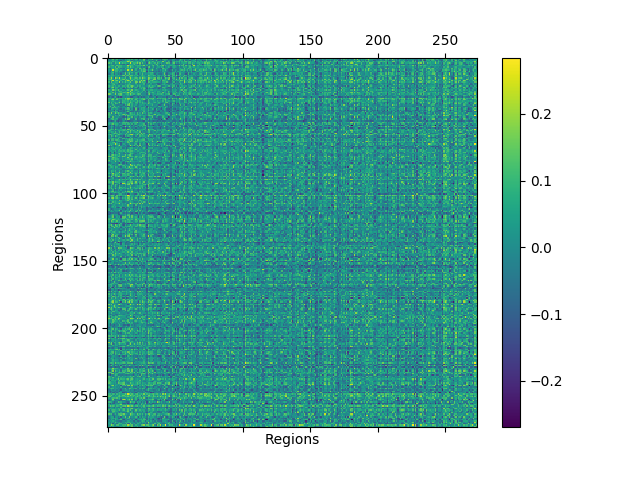

F_onewayResult(statistic=array([ 0.95348508]), pvalue=array([ 0.56458065]))


<IPython.core.display.Javascript object>


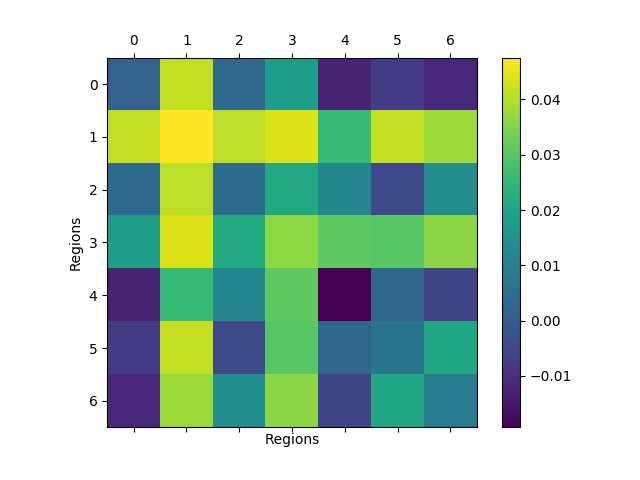

F_onewayResult(statistic=array([ 0.63377782]), pvalue=array([ 0.97568049]))


<IPython.core.display.Javascript object>


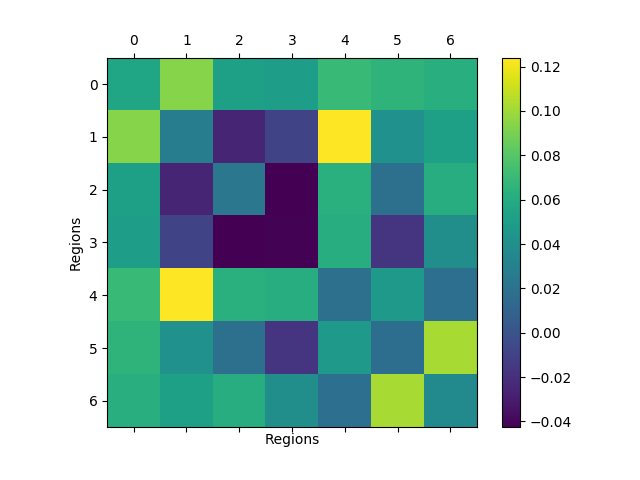

In [67]:
fig = plotRegionalChange(subjects, nullRSreducer)
fig = plotRegionalChange(subjects, yeoRSreducer)
fig = plotRegionalChange(subjects, clusteringRSreducer)

# Better ML stuff

In [ ]:
from sklearn import svm

In [ ]:
reducer = nullFSreducer

subjects['reducedPre'] = [reducer(subj, True) for subj in subjects.data]
subjects['reducedPost'] = [reducer(subj, False) for subj in subjects.data]

In [ ]:
svmTraining = pd.DataFrame()

svmTraining = svmTraining.append(pd.DataFrame({
    'data':subjects.reducedPre, 
    'time':'Pre', 
    'subject':subjects.index}))

svmTraining = svmTraining.append(pd.DataFrame({
    'data':subjects.reducedPost, 
    'time':'Post', 
    'subject':subjects.index}))

svmTraining.index = svmTraining.subject
svmTraining.sort_index(inplace=True)

svmTraining.head()

In [ ]:
classifier = svm.SVC()

classifier.fit(np.stack(svmTraining.data.values), svmTraining.time.values)

## Validation

In [ ]:
testingSubjects = loadData('validation')
testingSubjects

In [ ]:
reducer = nullFSreducer

testingSubjects['reducedPre'] = [reducer(subj, True) for subj in testingSubjects.data]
testingSubjects['reducedPost'] = [reducer(subj, False) for subj in testingSubjects.data]

In [ ]:
svmTesting = pd.DataFrame()

svmTesting = svmTesting.append(pd.DataFrame({
    'data':testingSubjects.reducedPre, 
    'time':'Pre', 
    'subject':testingSubjects.index}))

svmTesting = svmTesting.append(pd.DataFrame({
    'data':testingSubjects.reducedPost, 
    'time':'Post', 
    'subject':testingSubjects.index}))

svmTesting.index = svmTesting.subject
svmTesting.sort_index(inplace=True)

svmTesting.head()

In [ ]:
svmTesting['results'] = classifier.predict(np.stack(svmTesting.data.values))

print "Success rate: {} / {}".format(
    np.count_nonzero(svmTesting.time == svmTesting.results),
    len(svmTesting.time))

svmTesting